In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from HFCs_bmimPF6_PR import configuration

In [3]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

In [4]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [5]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [6]:
# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(298)
m.fs.F101.inlet.pressure.fix(250000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(298)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [7]:
# m.fs.F101.initialize(outlvl=idaeslog.INFO_HIGH)
m.fs.F101.initialize()

2022-03-17 14:35:07 [INFO] idaes.init.fs.F101.control_volume.properties_in: Starting initialization
2022-03-17 14:35:08 [INFO] idaes.init.fs.F101.control_volume.properties_in: Dew and bubble point initialization: optimal - Optimal Solution Found.
2022-03-17 14:35:08 [INFO] idaes.init.fs.F101.control_volume.properties_in: Equilibrium temperature initialization completed.
2022-03-17 14:35:09 [INFO] idaes.init.fs.F101.control_volume.properties_in: Phase equilibrium initialization: optimal - Optimal Solution Found.
2022-03-17 14:35:11 [INFO] idaes.init.fs.F101.control_volume.properties_in: Property initialization: optimal - Optimal Solution Found.
2022-03-17 14:35:11 [INFO] idaes.init.fs.F101.control_volume.properties_out: Starting initialization
2022-03-17 14:35:12 [INFO] idaes.init.fs.F101.control_volume.properties_out: Dew and bubble point initialization: optimal - Optimal Solution Found.
2022-03-17 14:35:12 [INFO] idaes.init.fs.F101.control_volume.properties_out: Equilibrium temperatur

In [8]:
result = solver.solve(m, tee=True)

Ipopt 3.13.2: tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

In [10]:
IL_z = [0.001,0.4,0.72,0.91,0.99]

IL_x = np.zeros((len(IL_z)))
IL_y = np.zeros((len(IL_z)))
R32_x = np.zeros((len(IL_z)))
R32_y = np.zeros((len(IL_z)))
R125_x = np.zeros((len(IL_z)))
R125_y = np.zeros((len(IL_z))) 
Z = []

# Constant M1
# m.fs.props.PR_kappa_A['R32', 'R125'].fix(0.009)
# m.fs.props.PR_kappa_A['R125', 'R32'].fix(0.007)
# m.fs.props.PR_kappa_A['R32', 'bmimPF6'].fix(-0.02608)
# m.fs.props.PR_kappa_A['bmimPF6', 'R32'].fix(-0.0704)
# m.fs.props.PR_kappa_A['bmimPF6', 'R125'].fix(0.345)
# m.fs.props.PR_kappa_A['R125', 'bmimPF6'].fix(0.058856)

# Linear M2
# m.fs.props.PR_kappa_A['R32', 'R125'].fix(0.39255)
# m.fs.props.PR_kappa_A['R125', 'R32'].fix(-0.375437)
# m.fs.props.PR_kappa_A['R32', 'bmimPF6'].fix(0.02700)
# m.fs.props.PR_kappa_A['bmimPF6', 'R32'].fix(0.26803)
# m.fs.props.PR_kappa_A['bmimPF6', 'R125'].fix(-1.601578)
# m.fs.props.PR_kappa_A['R125', 'bmimPF6'].fix(-0.111417)
# m.fs.props.PR_kappa_B['R32', 'R125'].fix(-0.389117)
# m.fs.props.PR_kappa_B['R125', 'R32'].fix(0.3892)
# m.fs.props.PR_kappa_B['R32', 'bmimPF6'].fix(-0.04879)
# m.fs.props.PR_kappa_B['bmimPF6', 'R32'].fix(-0.3153)
# m.fs.props.PR_kappa_B['bmimPF6', 'R125'].fix(2.086037)
# m.fs.props.PR_kappa_B['R125', 'bmimPF6'].fix(0.170299)

# ternary M3
# m.fs.props.PR_kappa_A['R32', 'R125'].fix(0.009)
# m.fs.props.PR_kappa_A['R125', 'R32'].fix(0.007)
# m.fs.props.PR_kappa_A['R32', 'bmimPF6'].fix(-0.043507)
# m.fs.props.PR_kappa_A['bmimPF6', 'R32'].fix(-0.35057)
# m.fs.props.PR_kappa_A['bmimPF6', 'R125'].fix(1.677866)
# m.fs.props.PR_kappa_A['R125', 'bmimPF6'].fix(0.060435)

# ternary weighted M4
# m.fs.props.PR_kappa_A['R32', 'R125'].fix(0.009)
# m.fs.props.PR_kappa_A['R125', 'R32'].fix(0.007)
# m.fs.props.PR_kappa_A['R32', 'bmimPF6'].fix(-0.0328315)
# m.fs.props.PR_kappa_A['bmimPF6', 'R32'].fix(-0.1130500)
# m.fs.props.PR_kappa_A['bmimPF6', 'R125'].fix(0.413767)
# m.fs.props.PR_kappa_A['R125', 'bmimPF6'].fix(0.059460)

# Ternary M5
m.fs.props.PR_kappa_A['R32', 'R125'].fix(0.39255)
m.fs.props.PR_kappa_A['R125', 'R32'].fix(-0.375437)
m.fs.props.PR_kappa_B['R32', 'R125'].fix(-0.389117)
m.fs.props.PR_kappa_B['R125', 'R32'].fix(0.3892)

m.fs.props.PR_kappa_A['bmimPF6', 'R125'].fix(-1.764584)
m.fs.props.PR_kappa_A['R125', 'bmimPF6'].fix(-0.161157)
m.fs.props.PR_kappa_A['bmimPF6', 'R32'].fix(-0.010645)
m.fs.props.PR_kappa_A['R32', 'bmimPF6'].fix(-0.024842)

m.fs.props.PR_kappa_B['bmimPF6', 'R125'].fix(2.123490)
m.fs.props.PR_kappa_B['R125', 'bmimPF6'].fix(0.21234)
m.fs.props.PR_kappa_B['bmimPF6', 'R32'].fix(-0.09102)
m.fs.props.PR_kappa_B['R32', 'bmimPF6'].fix(-0.00556)

for j in range(len(IL_z)):

    fract = 1 - IL_z[j]
    m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.2*IL_z[j])
    m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.2*fract)
    m.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.8)   
                  
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              

    # solve the model
    status = solver.solve(m, tee = False)
    # model.display()
    # If solution is optimal store the concentration, and calculated temperatures in the created arrays
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

        IL_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"])
        IL_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "bmimPF6"])
        R32_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
        R32_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
        R125_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
        R125_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

        print(j,'Feasible.')
    else:
        print(j,'Infeasible.')

0 Feasible.
1 Feasible.
2 Feasible.
3 Feasible.
4 Feasible.


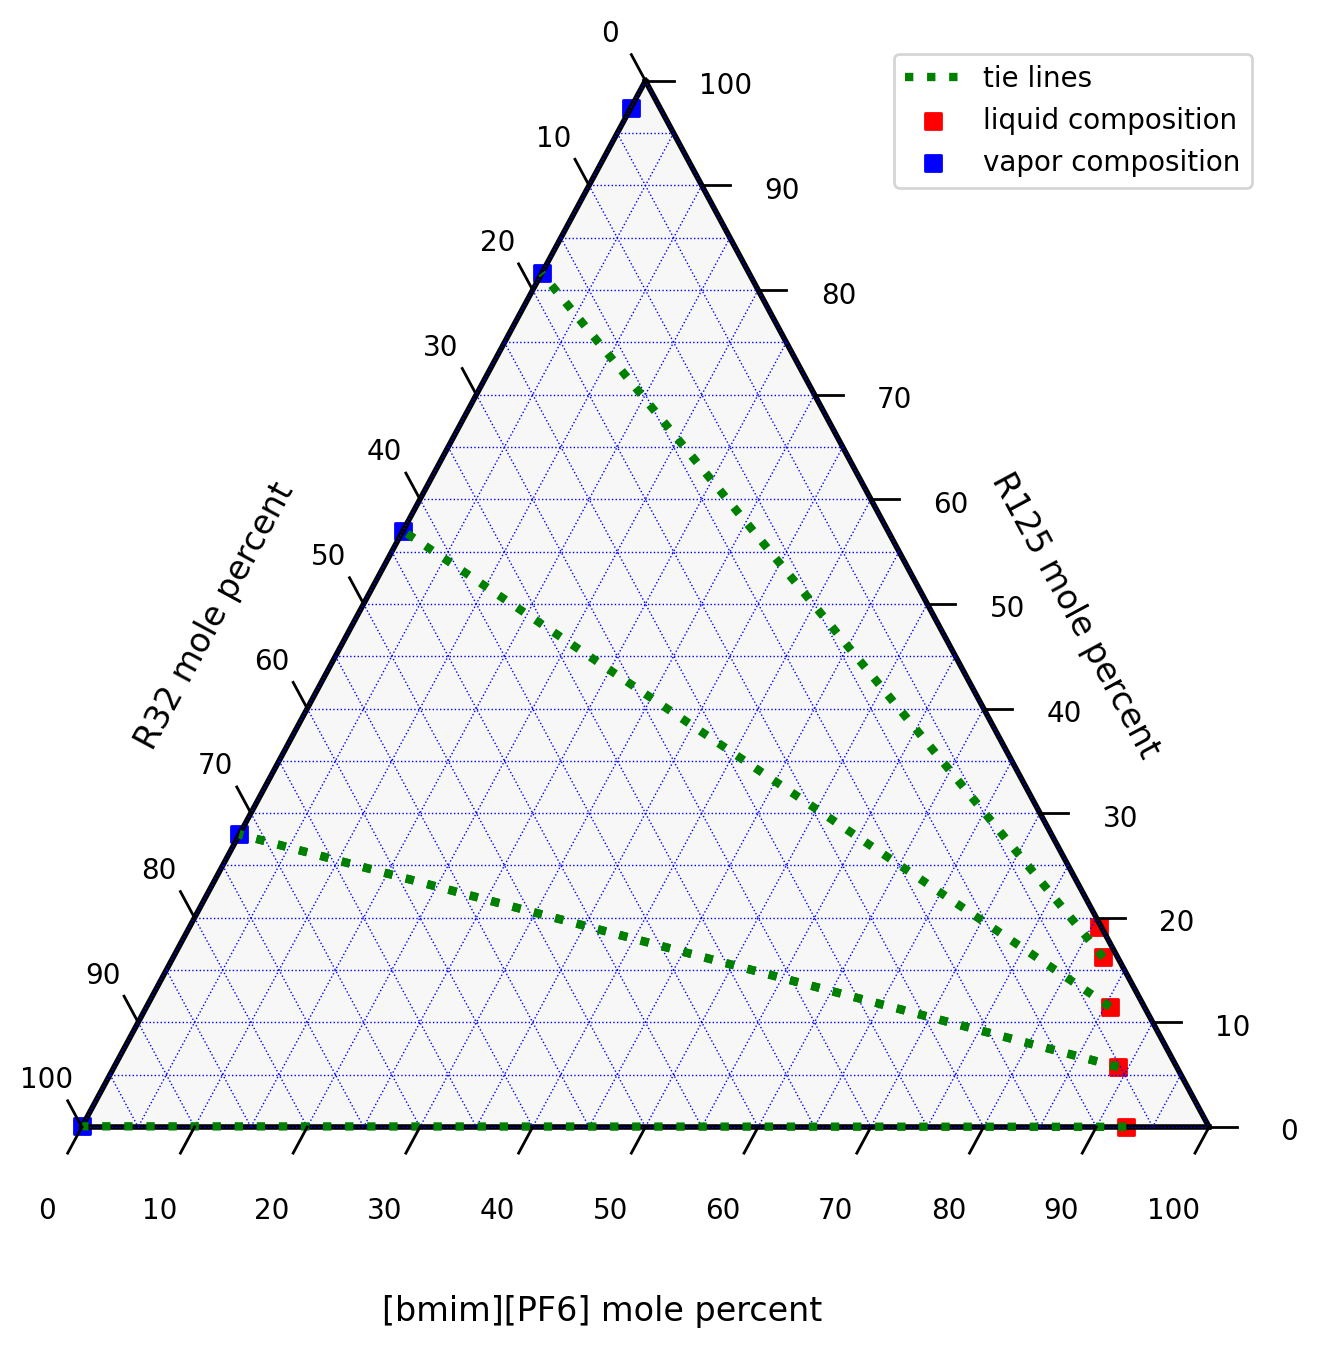

In [11]:
points_x = []

for i in range(len(IL_z)):
    points = (IL_x[i]*100, R32_x[i]*100, R125_x[i]*100)
    points_x.append(points)

points_y = []

for i in range(len(IL_z)):
    points = (IL_y[i]*100, R32_y[i]*100, R125_y[i]*100)
    points_y.append(points)

import ternary
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (8, 8)    
    
scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)


# # Set Axis labels and Title
# fontsize = 12
# offset = 0.14
# # tax.set_title("bmimPF6 1 bar\n from data", fontsize=24)
# tax.left_axis_label("R32", fontsize=fontsize, offset=offset)
# tax.right_axis_label("R125", fontsize=fontsize, offset=offset)
# tax.bottom_axis_label("IL", fontsize=fontsize, offset=offset)

# for i in range(len(IL_z)):
#     tax.line(points_x[i], points_y[i], linewidth=3., color='green', linestyle=":")

# tax.scatter(points_x, marker='s', color='red', label="liquid")
# tax.scatter(points_y, marker='s', color='blue', label="vapor")


# tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
# tax.get_axes().axis('off')
# tax.clear_matplotlib_ticks()
# tax.show()

fontsize = 12
offset = 0.14
# tax.set_title("Ternary phase diagram 8 bar\n", fontsize=24)
tax.left_axis_label("R32 mole percent", fontsize=fontsize, offset=offset)
tax.right_axis_label("R125 mole percent", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("[bmim][PF6] mole percent", fontsize=fontsize, offset=offset)

#for pressure changing plot would need to draw line between x[0] and x[final] for the indivual pressure
#use tax.line with the tax.scatter below
for i in range(4):
    tax.line(points_x[i], points_y[i], linewidth=3., color='green', linestyle=":")
tax.line(points_x[1], points_y[1], linewidth=3., color='green', linestyle=":", label="tie lines")
# make this tax.line
tax.scatter(points_x, marker='s', color='red', label="liquid composition")
#Comment out for pressure changing plot
tax.scatter(points_y, marker='s', color='blue', label="vapor composition")
tax.legend()
tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()

In [12]:
import pandas as pd

df = pd.DataFrame(columns=['IL_x', 'R32_x', 'R125_x','IL_y', 'R32_y', 'R125_y'])
df['IL_x'] = IL_x
df['R32_x'] = R32_x
df['R125_x'] = R125_x
df['IL_y'] = IL_y
df['R32_y'] = R32_y
df['R125_y'] = R125_y
df.to_csv('ternary_M5.csv')